# Load libraries

In [322]:
# Libraries import for running the code

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
import cartopy

# data exploration
import xarray as xr

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

This is the repository path:  c:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth
Had to go 0 folder(s) up.


# Load networks

In [323]:
#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

base_network= os.getcwd() +  "/networks/base.nc"
n_base= pypsa.Network(base_network) #network with all components available in the data sources

added_network = os.getcwd() +  "/networks/elec.nc"
n_add = pypsa.Network(added_network) #network with electrical parameters added to components in data sources 

simplified_network = os.getcwd() +  "/networks/elec_s.nc"
n_simple = pypsa.Network(simplified_network) #network with components simplified and spatial parameters (onshore and offshore regions) added  

clustered_network = os.getcwd() + '/networks/elec_s_6.nc'
n_cluster = pypsa.Network(clustered_network) #network simplified based on number of clusters given

prepared_network = os.getcwd() + "/networks/elec_s_6_ec_lcopt_Co2L-1H.nc"
n_prepared = pypsa.Network(prepared_network) #network defined and ready for optimization

solved_network = os.getcwd() + "/results/networks/elec_s_6_ec_lcopt_Co2L-1H.nc" # or: solved_network = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\..........\elec_s_22_ec_lcopt_Co2L-1H.nc"
n_solve = pypsa.Network(solved_network) #optimized network

n = n_solve

c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

# General outputs

In [324]:
##### check why the value does not appear 
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)
# Million Eur/Year
n
n.objective/1000000

344.28971326373664

In [325]:
n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,10983000.0,0.000005,primary_energy,NaN,co2_emissions


In [326]:
# estimation of the total emissions from the system in MtonCO2:

emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h

#snapshot_weightings provides the number of agregation used for each time step considered (4 hours in this case) and @ ins a multiplier
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt

3.3990365234826267

(<matplotlib.collections.PatchCollection at 0x24c992e3730>,
 <matplotlib.collections.LineCollection at 0x24c7d8f4250>)

c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


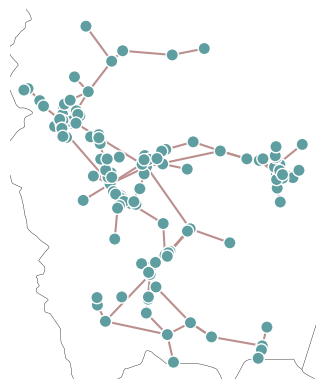

In [327]:
n_base.plot() #or n_base, n_cluster, n_simple

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\4155262218.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\4155262218.py:44: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


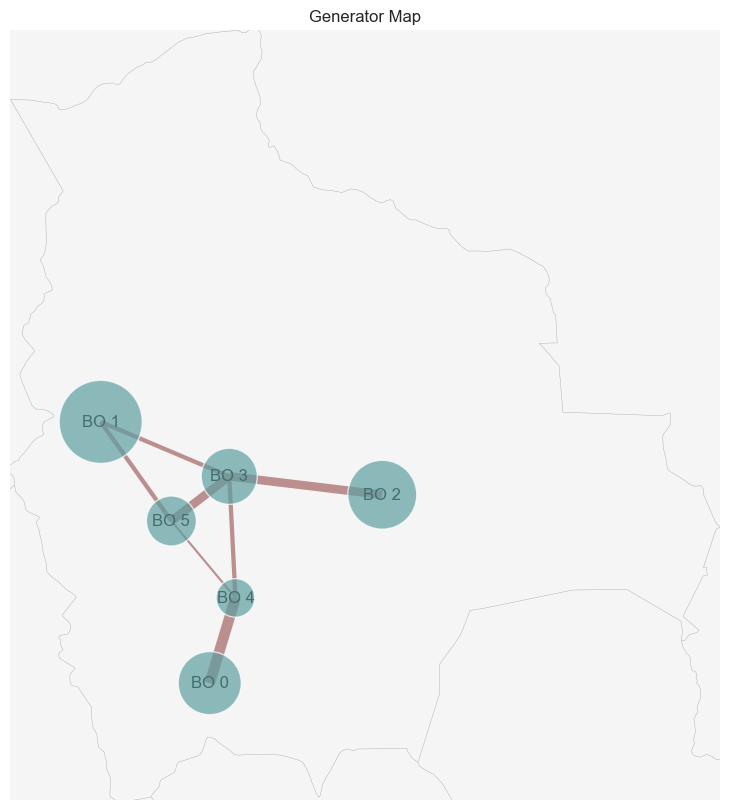

In [328]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=0.7,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    )*0.5,  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 1e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

# Convert "Bus" index column to string type
filtered_buses = n.buses
filtered_buses.index = filtered_buses.index.astype(str)
filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
# Add bus names to the plot
for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
    ax.text(lon, lat, bus, fontsize=12, color='black', ha='center', va='center')

ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


# Renewable resource exploration

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\1266236360.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


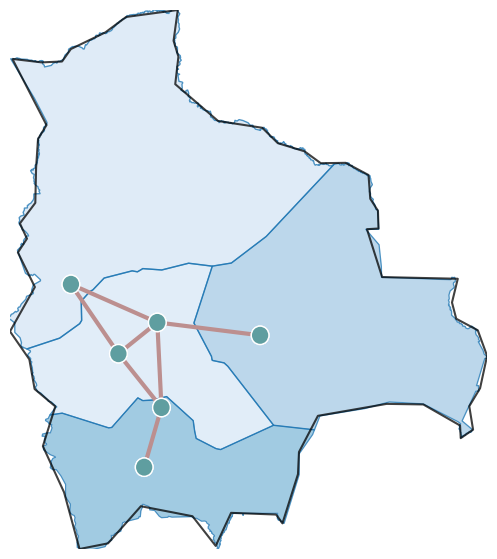

In [329]:
fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

cmap = "Blues"  # colormap for upper technology
red_linewidth = 3
red_bussizes = 5e-2
plot_capfacs = (
    "onwind"  # colors in the back represent capacity factors for this technology
)


#determine the limits of the country
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")
country=shapes

r = gpd.read_file(
        f"resources/bus_regions/regions_onshore_elec_s_4.geojson"
    ).set_index("name")
factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
r["factor"] = factor
    
n.plot(
        color_geomap=False,
        bus_sizes=red_bussizes,
        line_widths=red_linewidth,
        ax=ax,
    )

r.boundary.plot(ax=ax, color="tab:blue", linewidth=1, alpha=0.8)
r.plot(ax=ax, column="factor", cmap=cmap, alpha=1, vmin=0, vmax=1)
country.boundary.plot(ax=ax, color="black", alpha=0.75)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


# save the plot
#image_format = 'eps' # e.g .png, .svg, etc.
#fig.savefig('4zones_division_network.eps', format=image_format, dpi=1200)
plt.show()

In [330]:
cutout_path =  os.getcwd() +  "\cutouts\southamerica-2013-era5.nc"
cutout = xr.open_dataset(cutout_path)
cutout

<xarray.Dataset>
Dimensions:           (x: 45, y: 48, time: 8760)
Coordinates:
  * x                 (x) float64 -70.2 -69.9 -69.6 -69.3 ... -57.6 -57.3 -57.0
  * y                 (y) float64 -23.4 -23.1 -22.8 -22.5 ... -9.9 -9.6 -9.3
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon               (x) float64 ...
    lat               (y) float64 ...
Data variables: (12/13)
    height            (y, x) float32 ...
    wnd100m           (time, y, x) float32 ...
    wnd_azimuth       (time, y, x) float32 ...
    roughness         (time, y, x) float32 ...
    influx_toa        (time, y, x) float32 ...
    influx_direct     (time, y, x) float32 ...
    ...                ...
    albedo            (time, y, x) float32 ...
    solar_altitude    (time, y, x) float64 ...
    solar_azimuth     (time, y, x) float64 ...
    temperature       (time, y, x) float32 ...
    soil temperature  (time, y, x) float32 ...
    runoff            (time, y, x) float32 ...
Attributes:
    module:             era5
    prepared_features:  ['wind', 'temperature', 'height', 'influx', 'runoff']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2023-07-20 20:22:00 GMT by grib_to_netcdf-2.25.1: /op...

(array([12722311.,  1396404.,  1143128.,  1025719.,   956240.,   794579.,
          521970.,   247936.,    97308.,    16005.]),
 array([   0.     ,  117.92059,  235.84119,  353.76178,  471.68237,
         589.60297,  707.52356,  825.44415,  943.36475, 1061.2854 ,
        1179.2059 ], dtype=float32),
 <BarContainer object of 10 artists>)

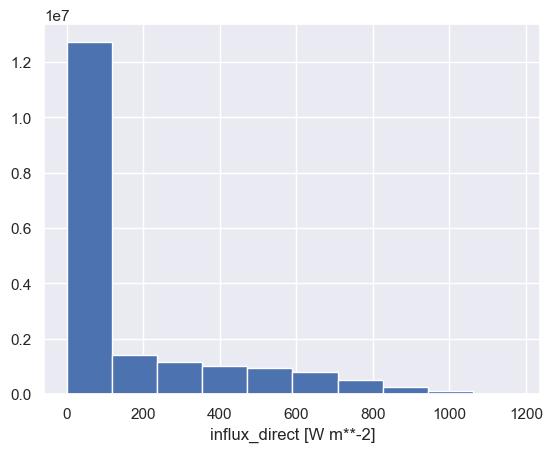

In [331]:
cutout.influx_direct.plot()

(array([5.460491e+06, 7.307506e+06, 4.225168e+06, 1.380594e+06,
        4.087820e+05, 1.078650e+05, 2.572900e+04, 4.619000e+03,
        7.700000e+02, 7.600000e+01]),
 array([9.6617860e-04, 2.0899158e+00, 4.1788654e+00, 6.2678151e+00,
        8.3567648e+00, 1.0445715e+01, 1.2534664e+01, 1.4623614e+01,
        1.6712564e+01, 1.8801514e+01, 2.0890463e+01], dtype=float32),
 <BarContainer object of 10 artists>)

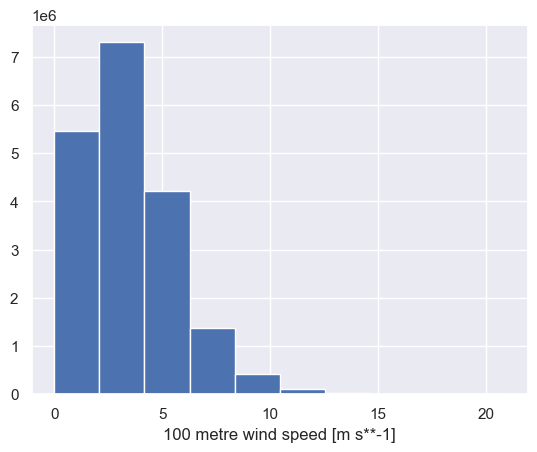

In [332]:
cutout.wnd100m.plot()

In [333]:
def plot_voronoi_potential(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(os.getcwd() + f"/resources/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([-57.25,  -69.38, -9.40, -22.54], crs=ccrs.PlateCarree())  # Bolivia
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")


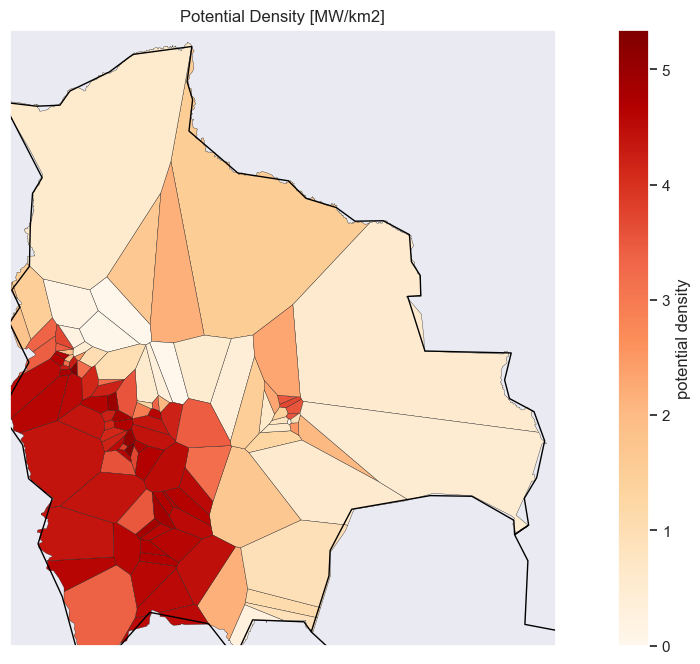

In [334]:
plot_voronoi_potential(
    n_add,
    "solar",
    "onshore",
    "OrRd",
    #ccrs.Orthographic(),    
    ccrs.PlateCarree(),
    title="Potential Density [MW/km2]",
    # filename="onwind-cell.pdf",
)

In [335]:
def plot_voronoi_cap_fac(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    g = n.generators_t.p_max_pu.filter(like=carrier, axis=1) #Filter out the type of generator to be plotted
    g.columns = g.columns.map(lambda x: x.split()[0]) #Rename the columns to keep only the numeric (first) part
    g_transposed = g.mean().transpose()
    br = gpd.read_file(os.getcwd() + f"/resources/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br["p_max_pu"] = g_transposed/2

    fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_max_pu",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_max_pu"].max(),
        legend=True,
        legend_kwds={"label": r"Capacity factor"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([-57.25,  -69.38, -9.40, -22.54], crs=ccrs.PlateCarree())  # Bolivia
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")


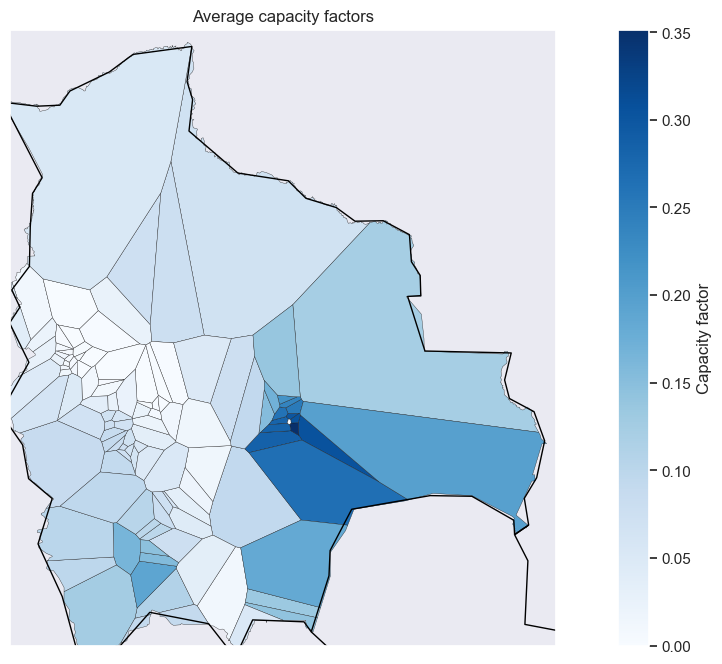

In [336]:
plot_voronoi_cap_fac(
    n_add,
    "onwind",
    "onshore",
    "Blues",
    #ccrs.Orthographic(),    
    ccrs.PlateCarree(),
    title="Average capacity factors",
    # filename="onwind-cell.pdf",
)

In [337]:
g1 = n_add.generators_t.p_max_pu.filter(like="onwind", axis=1) #Filter out the type of generator to be plotted
g1.columns = g1.columns.map(lambda x: x.split()[0]) #Rename the columns to keep only the numeric (first) part
g1_transposed = g1.mean().transpose()
br = gpd.read_file(os.getcwd() + f"/resources/bus_regions/regions_onshore.geojson").set_index("name")
br["CP"] = g1_transposed

g2 = n_add.generators.loc[n_add.generators.carrier == "onwind"]
br_area = br.to_crs("ESRI:54009")
br_area = br_area.geometry.area * 1e-6
br["p_nom_max"] = g2.groupby("bus").sum().p_nom_max

br_values = pd.DataFrame(index = br.index)
br_values["CP"] = br["CP"]
br_values["p_nom_max"] = br["p_nom_max"]
br_values.idxmax()

CP           114
p_nom_max    135
dtype: object

In [338]:
def plot_cap_fac_by_cluster(n, carrier, voronoi, simpl, clusters, cmap, projection, title=None, filename=None):

    g = n.generators_t.p_max_pu.filter(like=carrier, axis=1) #Filter out the type of generator to be plotted
    g.columns = g.columns.map(lambda x: " ".join(x.split()[:2])) #Rename the columns to keep only the first two components
    g_transposed = g.mean().transpose()
    br = gpd.read_file(os.getcwd() + f"/resources/bus_regions/regions_{voronoi}_elec_s{simpl}_{clusters}.geojson").set_index("name")
    br["p_max_pu"] = g_transposed

    fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_max_pu",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_max_pu"].max(),
        legend=True,
        legend_kwds={"label": r"Capacity factor"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([-57.25,  -69.38, -9.40, -22.54], crs=ccrs.PlateCarree())  # Bolivia
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")


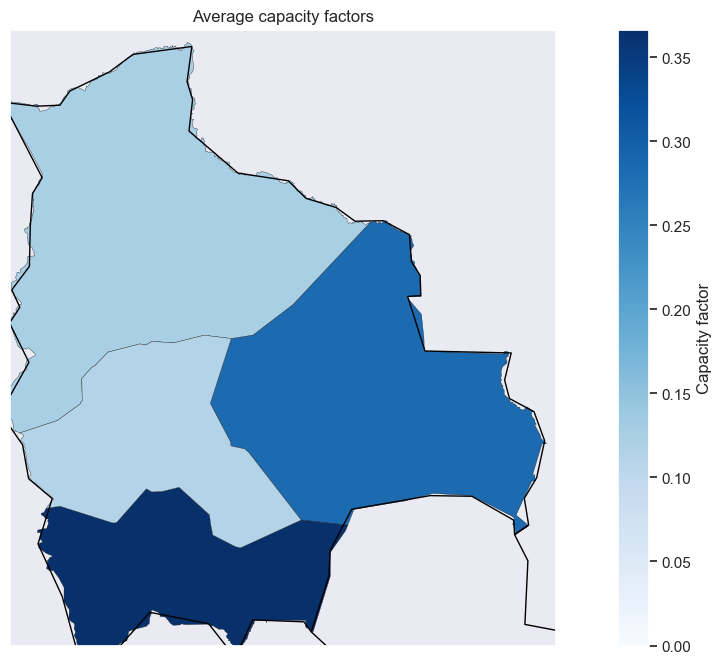

In [339]:
plot_cap_fac_by_cluster(
    n_cluster,
    "onwind",
    "onshore",
    "",
    "4",
    "Blues",
    #ccrs.Orthographic(),    
    ccrs.PlateCarree(),
    title="Average capacity factors",
    # filename="onwind-cell.pdf",
)

In [340]:
cf_solar_max = n.generators_t.p_max_pu.filter(regex='solar').max(axis=1)
#cf_solar_max.to_excel(r"C:\Users\Carlos\Desktop\capacity_factor_max_solar.xlsx")
cf_solar_min = n.generators_t.p_max_pu.filter(regex='solar').min(axis=1)
#cf_solar_min.to_excel(r"C:\Users\Carlos\Desktop\capacity_factor_min_solar.xlsx")
cf_solar_mean = n.generators_t.p_max_pu.filter(regex='solar').mean(axis=0)
cf_solar_mean

Generator
BO 0 solar    0.239692
BO 1 solar    0.183674
BO 2 solar    0.162381
BO 3 solar    0.189422
BO 4 solar    0.213604
BO 5 solar    0.238403
dtype: float64

In [341]:
cf_wind_max = n.generators_t.p_max_pu.filter(regex='onwind').max(axis=1)
#cf_wind.to_excel(r"C:\Users\Carlos\Desktop\capacity_factor_max_wind.xlsx")
cf_wind_min = n.generators_t.p_max_pu.filter(regex='onwind').min(axis=1)
#cf_wind.to_excel(r"C:\Users\Carlos\Desktop\capacity_factor_min_wind.xlsx")
cf_wind_mean = n.generators_t.p_max_pu.filter(regex='onwind').mean(axis=0)
cf_wind_mean

Generator
BO 0 onwind    0.284018
BO 1 onwind    0.124509
BO 2 onwind    0.366236
BO 3 onwind    0.113247
BO 4 onwind    0.154468
BO 5 onwind    0.165448
dtype: float64

In [342]:
#calculate capacity factors for a technology
Gen = "OCGT"
n.generators_t.p.filter(like= Gen).sum().sum() / n.generators.p_nom_opt.filter(like=Gen).sum() / 8760

0.6187217133363881

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\1650425330.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean().plot(kind = "area")


<AxesSubplot:xlabel='snapshot'>

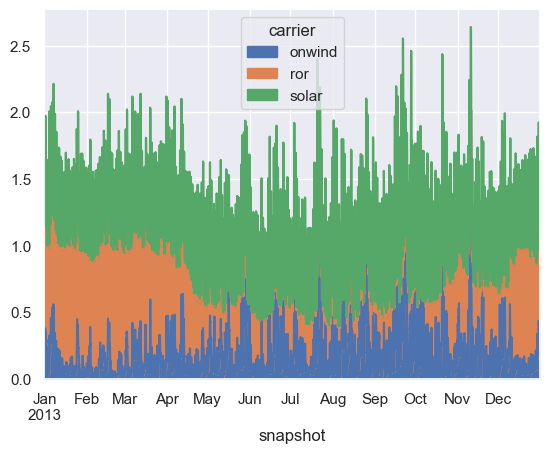

In [343]:
n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean().plot(kind = "area")

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\1974773131.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2013-03-07"].groupby(n.generators.carrier, axis=1).mean()


<AxesSubplot:xlabel='snapshot'>

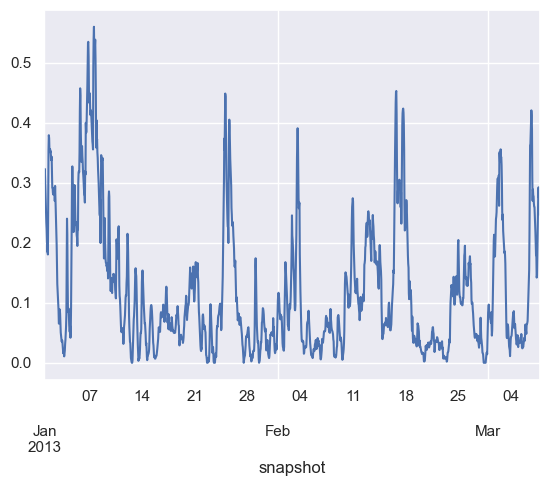

In [344]:
capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2013-03-07"].groupby(n.generators.carrier, axis=1).mean()
capacity_factor['onwind'].plot()

# Check line capacities

In [345]:
n.line_types

,f_nom,r_per_length,x_per_length,c_per_length,i_nom,mounting,cross_section,references
LineType,,,,,,,,
149-AL1/24-ST1A 10.0,50.0,0.19400,0.315000,11.25,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...
149-AL1/24-ST1A 110.0,50.0,0.19400,0.410000,8.75,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...
149-AL1/24-ST1A 20.0,50.0,0.19400,0.337000,10.50,0.470,ol,149.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...
15-AL1/3-ST1A 0.4,50.0,1.87690,0.350000,11.00,0.105,ol,16.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...
184-AL1/30-ST1A 110.0,50.0,0.15710,0.400000,8.80,0.535,ol,184.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...
184-AL1/30-ST1A 20.0,50.0,0.15710,0.330000,10.75,0.535,ol,184.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...
24-AL1/4-ST1A 0.4,50.0,1.20120,0.335000,11.25,0.140,ol,24.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...
243-AL1/39-ST1A 110.0,50.0,0.11880,0.390000,9.00,0.645,ol,243.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...
243-AL1/39-ST1A 20.0,50.0,0.11880,0.320000,11.00,0.645,ol,243.0,pandapower;Heuck et al. Elektrische Energieversorgung 8. Auflage (...


In [346]:
n.lines

,bus0,bus1,length,carrier,type,s_max_pu,s_nom,capital_cost,num_parallel,s_nom_extendable,s_nom_min,x,r,b,build_year,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,g,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,BO 0,BO 4,209.565403,AC,305-AL1/39-ST1A 110.0,0.7,736.987619,7987.002765,2.613636,True,770.487056,30.468987,7.609229,0.001583,0,0.000576,0.000144,770.497281,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,BO 1,BO 3,318.413525,AC,305-AL1/39-ST1A 110.0,0.7,294.795047,12130.571006,1.045455,True,308.194822,115.736394,28.903642,0.000962,0,0.002188,0.000546,308.197302,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,BO 1,BO 5,283.820676,AC,305-AL1/39-ST1A 110.0,0.7,294.795047,10813.700786,1.045455,True,308.194822,103.162646,25.763513,0.000858,0,0.001950,0.000487,308.198066,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,BO 2,BO 3,348.108505,AC,305-AL1/39-ST1A 110.0,0.7,589.590095,13262.733156,2.090909,True,616.389645,63.264937,15.799586,0.002104,0,0.001196,0.000299,616.391623,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,BO 3,BO 4,288.084052,AC,305-AL1/39-ST1A 110.0,0.7,294.795047,10979.888202,1.045455,True,308.194822,104.712290,26.150517,0.000870,0,0.001979,0.000494,308.249256,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,BO 3,BO 5,167.931581,AC,305-AL1/39-ST1A 110.0,0.7,589.590095,6397.921257,2.090909,True,616.389645,30.519739,7.621903,0.001015,0,0.000577,0.000144,616.429079,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,BO 4,BO 5,231.856374,AC,305-AL1/39-ST1A 110.0,0.7,147.397524,8833.054578,0.522727,True,154.097411,168.549503,42.093021,0.000350,0,0.003186,0.000796,154.098686,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [347]:
line_expansion_cost = n.lines.s_nom_opt*432.97*n.lines.length # investment cost of transmission lines (Eur/MW)
print("Investment costs for line expansion: " + str(line_expansion_cost.sum()/1000000*(9.5+2.5)/2.5) + " Million Eur, including mid and low voltage") 

Investment costs for line expansion: 1641.1910302440797 Million Eur, including mid and low voltage


In [348]:
#costs associated to VRES for energy scope in Eur/MW
VRES_capacity = n.generators.p_nom_opt.filter(like="onwind").sum() + n.generators.p_nom_opt.filter(like="solar").sum()
VRES_line_exp_costs = line_expansion_cost.sum() / VRES_capacity
VRES_line_exp_costs*12/2.5

6659291.220558223

# Generation expansion analysis

In [349]:
# Check generators total capacities nominal (p_nom) optimized (p_nom_opt) 
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,marginal_cost_quadratic,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,inf,0.000000,1.236330e+02,481119.229695,1.8780,123.633,53.867435,4,BO 0BO 1BO 2BO 3,Slack,8.914431e+02,4.000,0,0,0,4,0,,0.0,4.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,4.0,4.0
OCGT,inf,0.000000,3.200000e-02,404327.845622,1.2984,0.032,70.752624,4,BO 0BO 1BO 3BO 4,,6.398729e-02,4.000,0,0,0,4,0,,0.0,4.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,4.0,4.0
biomass,inf,0.000000,9.902000e+01,485991.250945,0.8898,99.020,70.834299,3,BO 1BO 2BO 3,,7.180125e+02,3.000,0,0,0,3,0,,0.0,3.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,3.0,3.0
geothermal,inf,0.000000,5.500000e+01,300336.444860,0.2390,55.000,0.010487,1,BO 0,,5.500360e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
load,inf,0.000000,6.000000e+09,0.000000,6.0000,0.000,600.059694,0,BO 0BO 1BO 2BO 3BO 4BO 5,PQPQPQPQPQPQ,6.000000e+09,0.006,0,0,0,6,0,,0.0,6.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,6.0,6.0
oil,inf,0.000000,3.100000e-02,147050.123161,1.4760,0.031,1349.672641,4,BO 0BO 1BO 2BO 3,,4.189785e-01,4.000,0,0,0,4,0,,0.0,4.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,4.0,4.0
onwind,2.375888e+06,384811.469743,1.458000e+02,718121.840912,6.0000,145.800,0.151383,6,BO 0BO 1BO 2BO 3BO 4BO 5,,1.458444e+02,6.000,0,0,0,6,0,,0.0,6.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,6.0,6.0
ror,inf,863.770000,8.637700e+02,803240.125252,4.5000,0.000,0.048021,0,BO 0BO 1BO 3BO 4BO 5,,8.637700e+02,5.000,0,0,0,5,0,,0.0,5.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,5.0,5.0
solar,1.869812e+06,383358.853267,1.004000e+02,305135.749602,6.0000,100.400,0.120390,6,BO 0BO 1BO 2BO 3BO 4BO 5,,1.006069e+02,6.000,0,0,0,6,0,,0.0,6.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,6.0,6.0


In [350]:
gen_cap.p_nom_opt

carrier
CCGT          8.914431e+02
OCGT          6.398729e-02
biomass       7.180125e+02
geothermal    5.500360e+01
load          6.000000e+09
oil           4.189785e-01
onwind        1.458444e+02
ror           8.637700e+02
solar         1.006069e+02
Name: p_nom_opt, dtype: float64

In [351]:
stores_cap = n.storage_units.groupby(["carrier"]).sum()
stores_cap.p_nom_opt

carrier
hydro    1295.32
Name: p_nom_opt, dtype: float64

In [352]:
#installed capacity expansion
generation_expansion = gen_cap['p_nom_opt'] - gen_cap['p_nom']
generation_expansion

carrier
CCGT          767.810055
OCGT            0.031987
biomass       618.992537
geothermal      0.003604
load            0.000000
oil             0.387978
onwind          0.044409
ror             0.000000
solar           0.206899
dtype: float64

In [353]:
generation_expansion.sum()

1387.477468711426

# Transmission expansion analysis

In [354]:
alternative_network = os.getcwd() + '/networks/base.nc' #'/networks/elec_s_4.nc' #
n_line = pypsa.Network(alternative_network)
check_lines = n_line.lines
check_lines.s_nom.mean()

c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

149.89514098862577

In [355]:
#Transmission lines 
lines = n.lines
lines

,bus0,bus1,length,carrier,type,s_max_pu,s_nom,capital_cost,num_parallel,s_nom_extendable,s_nom_min,x,r,b,build_year,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,g,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,BO 0,BO 4,209.565403,AC,305-AL1/39-ST1A 110.0,0.7,736.987619,7987.002765,2.613636,True,770.487056,30.468987,7.609229,0.001583,0,0.000576,0.000144,770.497281,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,BO 1,BO 3,318.413525,AC,305-AL1/39-ST1A 110.0,0.7,294.795047,12130.571006,1.045455,True,308.194822,115.736394,28.903642,0.000962,0,0.002188,0.000546,308.197302,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,BO 1,BO 5,283.820676,AC,305-AL1/39-ST1A 110.0,0.7,294.795047,10813.700786,1.045455,True,308.194822,103.162646,25.763513,0.000858,0,0.001950,0.000487,308.198066,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,BO 2,BO 3,348.108505,AC,305-AL1/39-ST1A 110.0,0.7,589.590095,13262.733156,2.090909,True,616.389645,63.264937,15.799586,0.002104,0,0.001196,0.000299,616.391623,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,BO 3,BO 4,288.084052,AC,305-AL1/39-ST1A 110.0,0.7,294.795047,10979.888202,1.045455,True,308.194822,104.712290,26.150517,0.000870,0,0.001979,0.000494,308.249256,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,BO 3,BO 5,167.931581,AC,305-AL1/39-ST1A 110.0,0.7,589.590095,6397.921257,2.090909,True,616.389645,30.519739,7.621903,0.001015,0,0.000577,0.000144,616.429079,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,BO 4,BO 5,231.856374,AC,305-AL1/39-ST1A 110.0,0.7,147.397524,8833.054578,0.522727,True,154.097411,168.549503,42.093021,0.000350,0,0.003186,0.000796,154.098686,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [356]:
lines.s_nom

Line
1    736.987619
2    294.795047
3    294.795047
4    589.590095
5    294.795047
6    589.590095
7    147.397524
Name: s_nom, dtype: float64

In [357]:
#transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']
transmission_expansion

Line
1    33.509663
2    13.402254
3    13.403019
4    26.801528
5    13.454208
6    26.838984
7     6.701163
dtype: float64

In [358]:
real_expansion = 0
for i in range(len(transmission_expansion)):  # Iterate over the indices of the Series
    if transmission_expansion.iloc[i] > 0:  # Check if the expansion value is greater than 0
        real_expansion += transmission_expansion.iloc[i]  # Add the expansion value to real_expansion

print("Total expansion of the system:", real_expansion)

Total expansion of the system: 134.11081870233684


In [359]:
max_line_expansion = transmission_expansion.max()
max_line_expansion

33.50966267890715

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\3131219818.py:165: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\3131219818.py:175: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


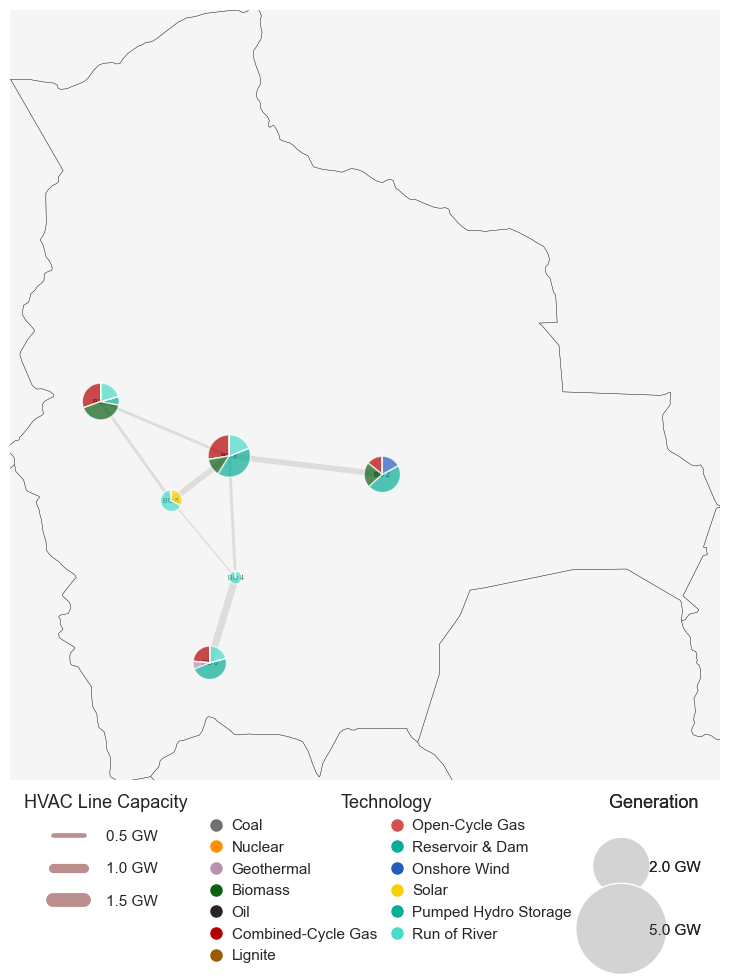

In [360]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=1.2,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    # Filter n.carriers to only exclude "H2" and "batteries"
    filtered_carriers = n.carriers.loc[~n.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )

        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [20, 50]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.2,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 9.0e3
    branch_factor = 15e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=100):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
    # Add bus names to the plot
    for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
        ax.text(lon, lat, bus, fontsize=5, color='black', ha='center', va='center')


    add_legend(ax, bus_factor, branch_factor)

    ### section added to define the national border
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes=world[world.name.isin(["Bolivia"])].set_index("name")
    ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

In [361]:
#plot_network(n,r"C:\Users\Carlos\Desktop\generation.eps")

# Cost-related Operational parameters

In [362]:
n.objective/1000000

344.28971326373664

In [363]:
n.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                3.075912e-01         1.163159e+08   
            Combined-Cycle Gas     9.936119e-01         1.072226e+08   
            Geothermal             9.999672e-01         1.651959e+07   
            Oil                    1.639300e-03         1.540271e+04   
            Onshore Wind           3.661485e-01         1.745568e+07   
            Open-Cycle Gas         6.187217e-01         6.467961e+03   
            Run of River           6.450870e-01         1.387629e+08   
            Solar                  2.383056e-01         5.116460e+06   
            load                   5.547554e-13         0.000000e+00   
Line        AC                     1.602517e-01         3.008994e+07   
Link        battery charger        2.935892e-01         1.521138e+04   
            battery discharger     2.378074e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        3.966055e-01         0.000000e+00   
Store       Battery Storage        4.883311e-01         7.160236e+03   

                                Curtailment      Dispatch  Installed Capacity  \
            carrier                                                             
Generator   Biomass                0.000000  1.934684e+06        9.902000e+01   
            Combined-Cycle Gas     0.000000  7.759156e+06        1.236330e+02   
            Geothermal             0.000000  4.818158e+05        5.500000e+01   
            Oil                    0.000000  6.016642e+00        3.100000e-02   
            Onshore Wind          40.753761  4.677902e+05        1.458000e+02   
            Open-Cycle Gas         0.000000  3.468113e+02        3.200000e-02   
            Run of River          84.508174  4.881132e+06        8.637700e+02   
            Solar                 44.335283  2.100226e+05        1.004000e+02   
            load                   0.000000  2.915795e-02        6.000000e+09   
Line        AC                          NaN -3.243860e+05        2.947950e+03   
Link        battery charger             NaN -1.015933e+03        0.000000e+00   
            battery discharger          NaN -9.143400e+02        0.000000e+00   
Load        -                           NaN -2.023504e+07                 NaN   
StorageUnit Reservoir & Dam        0.000000  4.500283e+06        1.295320e+03   
Store       Battery Storage             NaN -7.806256e-16        0.000000e+00   

                                Market Value  Operational Expenditure  \
            carrier                                                     
Generator   Biomass             3.676917e+01             4.568081e+07   
            Combined-Cycle Gas  2.728533e+01             1.044909e+08   
            Geothermal          2.719700e+01             5.052916e+03   
            Oil                 2.456191e+03             2.030124e+03   
            Onshore Wind        2.366780e+01             1.214935e+04   
            Open-Cycle Gas      2.992045e+01             6.134452e+03   
            Run of River        2.527770e+01             4.671942e+04   
            Solar               2.339469e+01             4.360838e+03   
            load                2.927832e+04             2.916085e+03   
Line        AC                 -4.010776e-03                      NaN   
Link        battery charger     2.136341e+00             0.000000e+00   
            battery discharger -1.025478e+01             0.000000e+00   
Load        -                  -2.903558e+01                      NaN   
StorageUnit Reservoir & Dam     3.381555e+01             4.554628e+04   
Store       Battery Storage    -2.757732e+19             1.016440e-18   

                                Optimal Capacity       Revenue        Supply  \
            carrier                                                            
Generator   Biomass        

In [364]:
# Capital expenditure for optimized values (annual values based on p_nom_opt) [Eur/year]
n.statistics.capex().sum()

431527387.4166716

In [365]:
# Capital expenditure (annual values based on p_nom_opt) [Eur/year]
n.statistics.opex(aggregate_time="sum").sum()

150296645.76317948

In [366]:
#manual sum of components to obtain capex of the system [Million Eur/year]
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6).sum()  + (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6).sum() + (n.lines.s_nom_opt * n.lines.capital_cost).div(1e6).sum() + (n.stores.e_nom_opt * n.stores.capital_cost).div(1e6).sum()# M€/a
capex

431.5121760371115

In [367]:
#manual sum of components to obatin opex of the system [Million Eur/year]
opex = (n.snapshot_weightings.generators @ n.generators_t.p * (n.generators.marginal_cost).div(1e6)).sum() + (n.snapshot_weightings.generators @ n.storage_units_t.p * (n.storage_units.marginal_cost).div(1e6)).sum()  # M€/a
opex

150.29664576317944

In [368]:
#manual sum of components to obtain capex of only the expanded capacity (p_nom_opt-p_nom) [Million Eur/year]
capex2 = ((n.generators.p_nom_opt - n.generators.p_nom)* n.generators.capital_cost).div(1e6).sum()  + ((n.storage_units.p_nom_opt - n.storage_units.p_nom ) * n.storage_units.capital_cost).div(1e6).sum() + ((n.lines.s_nom_opt - n.lines.s_nom) * n.lines.capital_cost).div(1e6).sum() + ((n.stores.e_nom_opt - n.stores.e_nom) * n.stores.capital_cost).div(1e6).sum()# M€/a
capex2

193.97785513727462

# Expansion and generation charts 

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\2084180376.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n.generators_t.p.loc[date1:date1].groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")


<AxesSubplot:xlabel='snapshot'>

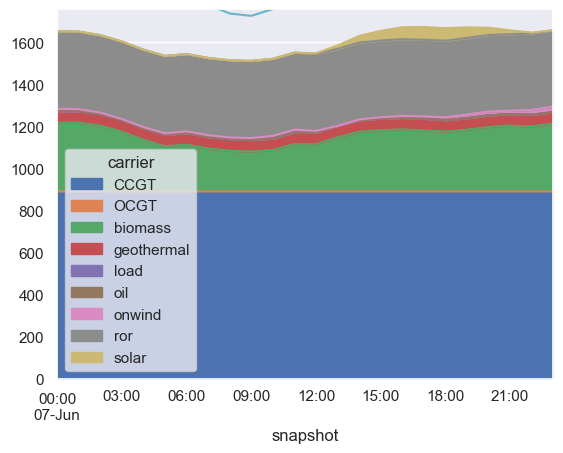

In [369]:
date1 = "2013-06-07"
date2 = "2014-01-01"
n.generators_t.p.loc[date1:date1].groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")
n.loads_t.p.loc[date1:date1].sum(axis=1).plot()

In [370]:
#defining colors for each technology
OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
ror_color='lightsteelblue'
reservoir_color='steelblue'
H2_color='darkgoldenrod'
battery_color='tan'
oil_color='grey'
biomass_color='#73A917'
demand_color='slategrey'
geothermal_color = 'purple'
aggregated_small_capacities = 'black'

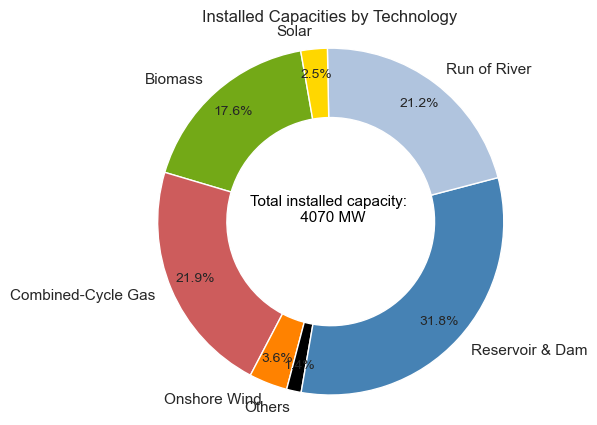

In [371]:
#selecting generation capacities from statistics
capacities = pd.DataFrame(n.statistics.optimal_capacity())
capacities = capacities.drop(index=['Line','Load','Link','Store'], level=0)
capacities = capacities.reset_index(level=0, drop=True)
capacities.rename(columns={0:"MW"}, inplace=True)
capacities.index.name = "Technology"
capacities = capacities.drop(index=['load'])
capacities['Percentage'] = capacities['MW']/capacities['MW'].sum()*100

#defining colors for each technology
H2_color='darkgoldenrod'
battery_color='tan'
demand_color='slategrey'
aggregated_small_capacities = 'black'

for i in range(len(capacities.index)):
    tech = capacities.index[i]  # Access the index value, which is the technology name
    if tech == "Open-Cycle Gas" : capacities.loc[tech, "Color"] = 'lightcoral'
    elif tech == "Combined-Cycle Gas" : capacities.loc[tech, "Color"] = 'indianred'
    elif tech == "Solar" : capacities.loc[tech, "Color"] = 'gold'
    elif tech == "Run of River" : capacities.loc[tech, "Color"] = 'lightsteelblue'
    elif tech == "Onshore Wind" : capacities.loc[tech, "Color"] = '#ff8200'
    elif tech == "Reservoir & Dam" : capacities.loc[tech, "Color"] = 'steelblue'
    elif tech == "Oil" : capacities.loc[tech, "Color"] = 'grey'
    elif tech == "Geothermal" : capacities.loc[tech, "Color"] = 'purple'
    elif tech == "Biomass" : capacities.loc[tech, "Color"] = '#73A917'

# Identify, adding and removing capacities smaller than 1%
small_capacities = capacities[capacities['Percentage'] < 2]
capacities.loc['Others'] = [small_capacities['MW'].sum(), small_capacities['Percentage'].sum(), aggregated_small_capacities]
capacities = capacities.drop(index=small_capacities.index)
capacities = capacities.sort_index()

#plotting the results

plt.figure(figsize=(5, 5))
plt.pie(capacities['MW'], labels=capacities.index, colors=capacities['Color'], autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_capacity = capacities['MW'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total installed capacity: \n {int(total_capacity)} MW', fontsize=11, color='black', ha='center')
plt.title('Installed Capacities by Technology')
plt.show()

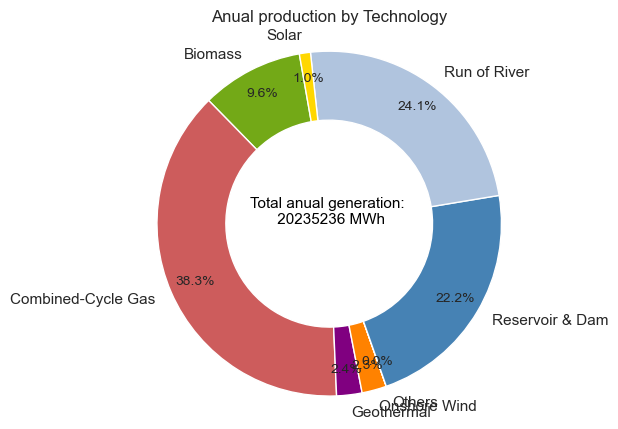

In [372]:
#selecting production from statistics
production = pd.DataFrame(n.statistics.dispatch())
production = production.drop(index=['Line','Load','Link','Store'], level=0)
production = production.reset_index(level=0, drop=True)
production.rename(columns={0:"MWh"}, inplace=True)
production.index.name = "Technology"
production = production.drop(index=['load'])
production['Percentage'] = production['MWh']/production['MWh'].sum()*100

#defining colors for each technology
H2_color='darkgoldenrod'
battery_color='tan'
demand_color='slategrey'
aggregated_small_capacities = 'black'

for i in range(len(production.index)):
    tech = production.index[i]  # Access the index value, which is the technology name
    if tech == "Open-Cycle Gas" : production.loc[tech, "Color"] = 'lightcoral'
    elif tech == "Combined-Cycle Gas" : production.loc[tech, "Color"] = 'indianred'
    elif tech == "Solar" : production.loc[tech, "Color"] = 'gold'
    elif tech == "Run of River" : production.loc[tech, "Color"] = 'lightsteelblue'
    elif tech == "Onshore Wind" : production.loc[tech, "Color"] = '#ff8200'
    elif tech == "Reservoir & Dam" : production.loc[tech, "Color"] = 'steelblue'
    elif tech == "Oil" : production.loc[tech, "Color"] = 'grey'
    elif tech == "Geothermal" : production.loc[tech, "Color"] = 'purple'
    elif tech == "Biomass" : production.loc[tech, "Color"] = '#73A917'


# Identify, adding and removing capacities smaller than 1%
small_production = production[production['Percentage'] < 1]
production.loc['Others'] = [small_production['MWh'].sum(), small_production['Percentage'].sum(), aggregated_small_capacities]
production = production.drop(index=small_production.index)
production = production.sort_index()

#plotting the results

plt.figure(figsize=(5, 5))
plt.pie(production['MWh'], labels=production.index, colors=production['Color'], autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_production = production['MWh'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total anual generation: \n {int(total_production)} MWh', fontsize=11, color='black', ha='center')
plt.title('Anual production by Technology')
plt.show()


####### or a different way to plot results for specific periods:

# import matplotlib.pyplot as plt
# first_date = "2013-01-01"
# second_date = "2014-01-01"

# time_aggregation = 1   #number hour hours considered by snapshot

# OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]*time_aggregation
# Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]*time_aggregation
# solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]*time_aggregation
# oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]*time_aggregation


# size = OCGT.shape[0]

# if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
#     ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]*time_aggregation
# else:
#     ror = np.zeros(size)
    
# if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
#     biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]*time_aggregation
# else:
#     biomass = np.zeros(size)
    
# if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
#     CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]*time_aggregation
# else:
#     CCGT = np.zeros(size)

# if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
#     H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]*time_aggregation
# else:
#     H2 = np.zeros(size)
    
# if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
#     battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]*time_aggregation
# else:
#     battery = np.zeros(size)

# if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
#     reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)*time_aggregation
# else:
#     reservoir = np.zeros(size)

# if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
#     geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
# else:
#     geothermal = np.zeros(size)


# # Original data
# labels = ['OCGT', 'CCGT', 'Solar', 'Run Of River', 'Reservoir', 'Onshore wind', 'Oil', 'Biomass', 'Geothermal']
# sizes = [OCGT.sum(), CCGT.sum(), solar.sum(), ror.sum(), reservoir.sum(),Onwind.sum(), oil.sum(), biomass.sum(), geothermal.sum()]
# colors = [OCGT_color, CCGT_color, Solar_color, ror_color, reservoir_color,Onwind_color, oil_color, biomass_color, geothermal_color]

# # Filter data based on size > 0.5
# filtered_labels = []
# filtered_sizes = []
# filtered_colors = []

# for label, size, color in zip(labels, sizes, colors):
#     if size > 10:
#         filtered_labels.append(label)
#         filtered_sizes.append(size)
#         filtered_colors.append(color)

# # Calculate the total sum of energy production
# total_production = sum(filtered_sizes)

# # Function to format the label text with actual values
# def format_label(value):
#     int_value = int(value)
#     return str(int_value)

# # Generate the pie chart
# plt.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
# plt.axis('equal')

# # Add the total energy annotation at the center of the pie chart
# plt.text(0, 0, f'Total Energy:\n{int(total_production)} MWh', fontsize=12, color='black', ha='center', va='center')

# #plt.savefig('energy_pie_run4.eps', format=image_format, dpi=1200)
# plt.show()


In [373]:
storage_capacities = pd.DataFrame(n.statistics.optimal_capacity())
storage_capacities = storage_capacities.drop(index=['Line','Generator','StorageUnit'], level=0)
storage_capacities

0
      carrier                     
Store Battery Storage     0.450957
Link  battery charger     0.395022
      battery discharger  0.438913

# Dispatch chart

In [374]:
#energy generated by type of powerplant
production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()
production_cap.sum()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\2440099205.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()


carrier
CCGT          7.759156e+06
OCGT          3.468113e+02
biomass       1.934684e+06
geothermal    4.818158e+05
load          2.915795e+01
oil           6.016642e+00
onwind        4.677902e+05
ror           4.881132e+06
solar         2.100226e+05
dtype: float64

In [375]:
test = n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]
test

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,carrier,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,marginal_cost_quadratic,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 solar,468659.421205,110315.350838,0.0,50855.958267,1.0,0.0,0.020501,True,BO 0,solar,,0.093520,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,551043.675533,98184.964867,0.0,50855.958267,1.0,0.0,0.020950,True,BO 1,solar,,0.021205,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 solar,231199.283268,37545.822772,0.0,50855.958267,1.0,0.0,0.019264,True,BO 2,solar,,0.018678,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 3 solar,82598.099645,15484.626201,0.0,50855.958267,1.0,0.0,0.019558,True,BO 3,solar,,0.025976,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 4 solar,207072.902785,43723.656232,0.0,50855.958267,1.0,0.0,0.019352,True,BO 4,solar,,0.038821,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 5 solar,329238.194818,78104.432357,100.4,50855.958267,1.0,100.4,0.020765,True,BO 5,solar,,100.408698,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [376]:
test2 = n.generators_t.p_max_pu.filter(regex='solar')
test2

Generator,BO 0 solar,BO 1 solar,BO 2 solar,BO 3 solar,BO 4 solar,BO 5 solar
snapshot,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2013-12-31 19:00:00,0.546207,0.470854,0.467397,0.474905,0.519522,0.504249
2013-12-31 20:00:00,0.411288,0.374581,0.418258,0.397404,0.398517,0.389336
2013-12-31 21:00:00,0.259897,0.247929,0.247290,0.281771,0.261327,0.251513


In [377]:
test3 = test2*test['p_nom_opt']
test3

Generator,BO 0 solar,BO 1 solar,BO 2 solar,BO 3 solar,BO 4 solar,BO 5 solar
snapshot,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2013-12-31 19:00:00,0.051081,0.009985,0.008730,0.012336,0.020168,50.631002
2013-12-31 20:00:00,0.038464,0.007943,0.007812,0.010323,0.015471,39.092687
2013-12-31 21:00:00,0.024306,0.005257,0.004619,0.007319,0.010145,25.254139


C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\1298311944.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]


<AxesSubplot:xlabel='snapshot'>

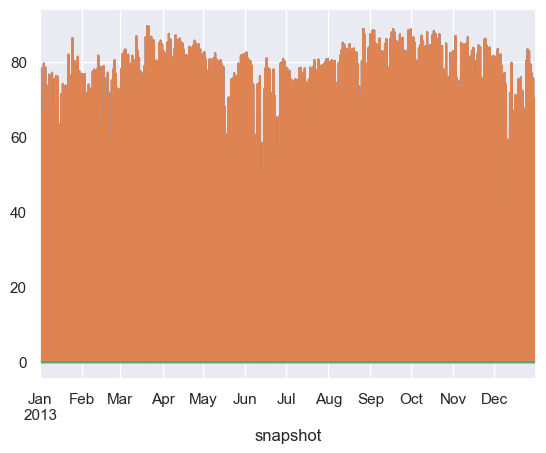

In [378]:
first_date = "2013-01-01"
second_date = "2014-01-01"

maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation


maximum_solar_generation.plot()
solar_generation.plot()
curtailment_solar.plot()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\3021325238.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\3021325238.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  wind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\3021325238.py:25: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\3021325238.py:26: FutureWarning: DataFrame.groupby with axis=1 is deprecat

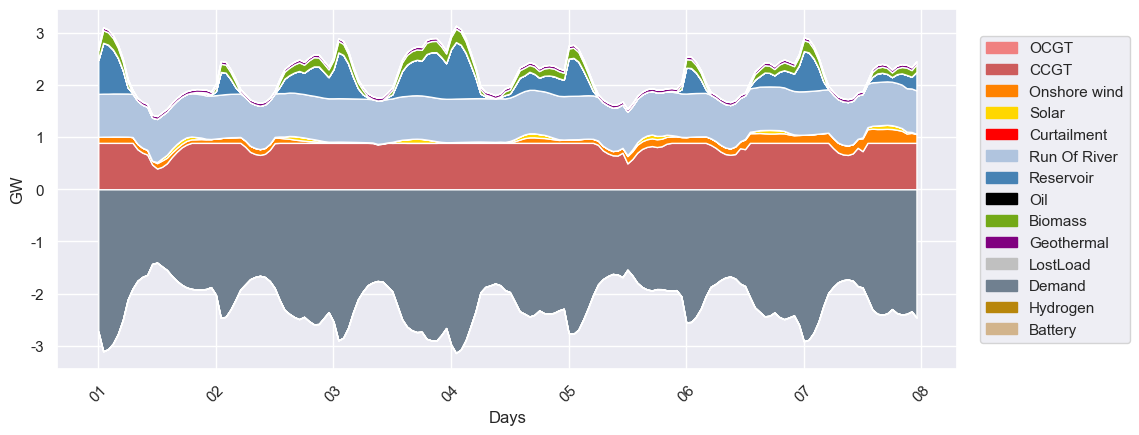

                   p_nom     p_nom_opt
carrier                               
CCGT        1.236330e+02  8.914431e+02
OCGT        3.200000e-02  6.398729e-02
biomass     9.902000e+01  7.180125e+02
geothermal  5.500000e+01  5.500360e+01
load        6.000000e+09  6.000000e+09
oil         3.100000e-02  4.189785e-01
onwind      1.458000e+02  1.458444e+02
ror         8.637700e+02  8.637700e+02
solar       1.004000e+02  1.006069e+02

hydro storage : p_nom: 1295.3200000000002  p_nom_opt: 1295.3200000000002
                    p_nom  p_nom_opt
carrier                             
battery charger       0.0   0.395022
battery discharger    0.0   0.438913


In [379]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

first_date = "2013-01-01"
second_date = "2013-01-07"

#Hourly solar curtailment calculation
maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation

#Hourly wind curtailment calculation
maximum_wind_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='onwind') * n.generators.loc[[idx for idx in n.generators.index if 'onwind' in idx]]['p_nom_opt']
maximum_wind_generation = maximum_wind_generation.sum(axis=1)
wind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
curtailment_wind = maximum_wind_generation- wind_generation

curtailment = curtailment_solar.loc[first_date:second_date] + curtailment_wind.loc[first_date:second_date]

#Hourly generation per technology
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]

#LoadShedding
load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]

#Hourly load/demand 
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
else:
    biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "load" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]/1000
else:
    load = np.zeros(size)

if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]
else:
    H2 = np.zeros(size)
    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    
if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)

#Hourly storage charge or discharge 
i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 

i=0
nH2 = []
pH2=[]
for i in H2:
    if i < 0:
        nH2.append(i)
    else:
        nH2.append(0) 
for i in H2:
    if i > 0:
        pH2.append(i)
    else:
        pH2.append(0) 

# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])

OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
curtailment_color = 'red'
ror_color='lightsteelblue'
reservoir_color='steelblue'
H2_color='darkgoldenrod'
battery_color='tan'
oil_color='black'
biomass_color='#73A917'
demand_color='slategrey'
geothermal_color = 'purple'
lostload_color = "silver"

A = plt.stackplot(OCGT.index, OCGT, CCGT, Onwind, solar, curtailment, ror,reservoir, pH2, pbattery, oil, biomass, geothermal,load,
colors=[OCGT_color,CCGT_color,Onwind_color,Solar_color,curtailment_color,ror_color,reservoir_color,H2_color,battery_color,oil_color,biomass_color,geothermal_color,lostload_color], zorder = 3)
plt.stackplot(OCGT.index,demand,nbattery,nH2, colors=[demand_color,battery_color,H2_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Days')

OCGT_patch = mpatches.Patch(color=OCGT_color, label ='OCGT')
CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
curtailment_patch = mpatches.Patch(color=curtailment_color, label = 'Curtailment')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')
H2_patch = mpatches.Patch(color=H2_color, label ='Hydrogen')
battery_patch = mpatches.Patch(color=battery_color, label ='Battery')
oil_patch = mpatches.Patch(color=oil_color, label ='Oil')
biomass_patch = mpatches.Patch(color=biomass_color, label ='Biomass')
load_patch = mpatches.Patch(color=demand_color, label ='Demand')
geothermal_patch = mpatches.Patch(color=geothermal_color, label ='Geothermal')
lostload_patch = mpatches.Patch(color=lostload_color, label ='LostLoad')

handles=[OCGT_patch,CCGT_patch,wind_patch,solar_patch,curtailment_patch,ror_patch,reservoir_patch,oil_patch,biomass_patch,geothermal_patch,lostload_patch,load_patch,H2_patch,battery_patch]

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.20, 0.5))

image_format = 'eps' # e.g .png, .svg, etc.

#fig.savefig(r'C:\Users\Carlos\Desktop\satand_alone_transition.eps', format=image_format, dpi=1200)

plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])


In [380]:
generator_list = ["CCGT","OCGT","oil","biomass","geothermal","onwind","solar","ror","load"]
for cols in generator_list :
    print(str(cols) + " generation (MWh) = " + str( round(n.generators_t.p.filter(like= cols).sum().sum())))

generator_list2 = ["hydro"]
for cols in generator_list2 :
    print(str(cols) + " generation (MWh) = " + str( round(n.storage_units_t.p.filter(like= cols).sum().sum())))

CCGT generation (MWh) = 7759156
OCGT generation (MWh) = 347
oil generation (MWh) = 6
biomass generation (MWh) = 1934684
geothermal generation (MWh) = 481816
onwind generation (MWh) = 467790
solar generation (MWh) = 210023
ror generation (MWh) = 4881132
load generation (MWh) = 29
hydro generation (MWh) = 4500283


In [381]:
n.stores.e_nom_opt.sum()

0.4509565828409881

In [382]:
n.generators.tail(8)

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,carrier,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,marginal_cost_quadratic,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 5 ror,inf,202.670000,2.026700e+02,160648.025050,0.9,0.0,0.009920,False,BO 5,ror,,2.026700e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 5 solar,3.292382e+05,78104.432357,1.004000e+02,50855.958267,1.0,100.4,0.020765,True,BO 5,solar,,1.004087e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 load,inf,NaN,1.000000e+09,0.000000,1.0,0.0,100.010451,False,BO 0,load,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 load,inf,NaN,1.000000e+09,0.000000,1.0,0.0,100.009405,False,BO 1,load,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 load,inf,NaN,1.000000e+09,0.000000,1.0,0.0,100.010447,False,BO 2,load,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 3 load,inf,NaN,1.000000e+09,0.000000,1.0,0.0,100.009507,False,BO 3,load,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 4 load,inf,NaN,1.000000e+09,0.000000,1.0,0.0,100.009936,False,BO 4,load,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 5 load,inf,NaN,1.000000e+09,0.000000,1.0,0.0,100.009948,False,BO 5,load,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


# LostLoad contribution

In [383]:
demand = n.loads_t.p_set.loc["2013-01-01":"2014-01-01"].sum(axis=1)
demand.idxmax()
demand.sum()

#demand.loc["2013-06-07"]

20235043.619063437

In [384]:
load_shedding = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()["load"]
round(load_shedding.sum())

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\1141493684.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  load_shedding = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()["load"]


29

In [385]:
#LL or Loadshedding is in kW/kWh 
lostload = n.generators_t.p.filter(like= "load")
#lostload.idxmax()
peakLL = pd.DataFrame(index = lostload.index)
peakLL["Peak LL"] = lostload.max(axis=1)/1000
sortedLL = peakLL.sort_values("Peak LL", ascending=False)
LL_contribution = sortedLL.iloc[0:9]
LL_contribution.max()

Peak LL    8.430146e-07
dtype: float64

In [386]:
contribution_wind = pd.DataFrame()
contribution_wind["wind generation"] = n.generators_t.p.filter(like="onwind").sum(axis=1)
contribution_wind.loc[LL_contribution.index].mean()

wind generation    271.774786
dtype: float64

In [387]:
contribution_solar = pd.DataFrame()
contribution_solar["solar generation"] = n.generators_t.p.filter(like="solar").sum(axis=1)
contribution_solar.loc[LL_contribution.index].mean()

solar generation    19.831622
dtype: float64

# Storage

In [388]:
n.links.carrier

Link
BO 0 battery charger          battery charger
BO 1 battery charger          battery charger
BO 2 battery charger          battery charger
BO 3 battery charger          battery charger
BO 4 battery charger          battery charger
BO 5 battery charger          battery charger
BO 0 battery discharger    battery discharger
BO 1 battery discharger    battery discharger
BO 2 battery discharger    battery discharger
BO 3 battery discharger    battery discharger
BO 4 battery discharger    battery discharger
BO 5 battery discharger    battery discharger
Name: carrier, dtype: object

C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\3326476034.py:170: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\3326476034.py:180: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


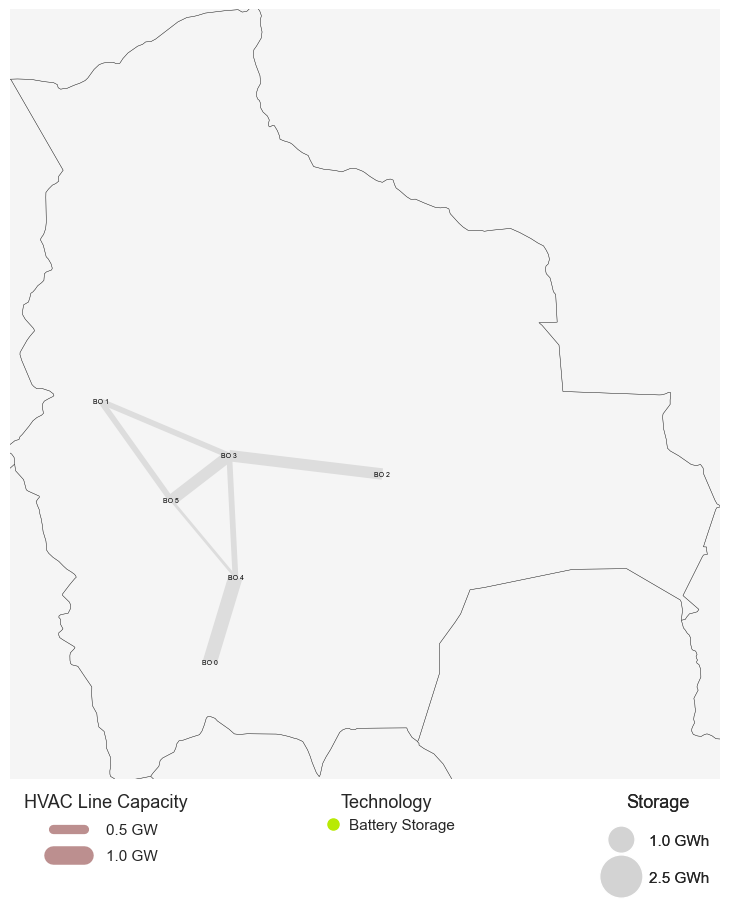

In [389]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    # Filter n.carriers to only include "H2" and "batteries"
    filtered_carriers = n.carriers.loc[n.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )
        labels.append(carrier.nice_name)
    
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 25]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GWh" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=1.5,
        title="Storage",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 2.0e4
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "e_nom","e_nom_opt"]
        
    pie_components = pd.concat(
        [
            #n.generators[fields],
            #n.storage_units[fields],
            n.stores[fields],
        ]
    )
    # Split the 'Node' index to separate the 'BO' part
    pie_components['bus'] = pie_components["bus"].str.extract(r'(BO \d+)')[0]

    bus_sizes = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
    # Add bus names to the plot
    for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
        ax.text(lon, lat, bus, fontsize=5, color='black', ha='center', va='center')


    add_legend(ax, bus_factor, branch_factor)

    ### section added to define the national border
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes=world[world.name.isin(["Bolivia"])].set_index("name")
    ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

In [390]:
#plot_network(n,r"C:\Users\Carlos\Desktop\storage.eps")

In [391]:
bus_factor = 2.0e4
branch_factor = 7.5e1

fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
pie_components = pd.concat(
        [
            n.generators[fields],
            #n.storage_units[fields],
            #n.stores[fields],
        ]
    )
# Split the 'Node' index to separate the 'BO' part
pie_components['bus'] = pie_components["bus"].str.extract(r'(BO \d+)')[0]

bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor
bus_sizes

bus   carrier   
BO 0  CCGT          8.657903e-03
      OCGT          8.079008e-07
      geothermal    2.750180e-03
      load          5.000000e+04
      oil           5.201367e-06
      onwind        6.185731e-07
      ror           7.500000e-03
      solar         4.676008e-06
BO 1  CCGT          1.353394e-02
      OCGT          7.675811e-07
      biomass       1.831799e-02
      load          5.000000e+04
      oil           5.279975e-06
      onwind        3.914492e-07
      ror           9.069500e-03
      solar         1.060259e-06
BO 2  CCGT          6.182604e-03
      biomass       9.714381e-03
      load          5.000000e+04
      oil           5.188440e-06
      onwind        7.290032e-03
      solar         9.339119e-07
BO 3  CCGT          1.619771e-02
      OCGT          8.201059e-07
      biomass       7.868253e-03
      load          5.000000e+04
      oil           5.279141e-06
      onwind        3.297782e-07
      ror           1.100800e-02
      solar         1.2988

In [392]:
bus_factor = 2.0e4
branch_factor = 7.5e1

fields = ["bus", "carrier", "e_nom","e_nom_opt"]
        
pie_components = pd.concat(
        [
            #n.generators[fields],
            #n.storage_units[fields],
            n.stores[fields],
        ]
    )

bus_sizes = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum() / bus_factor
bus_sizes

bus           carrier
BO 0 battery  battery    0.000004
BO 1 battery  battery    0.000004
BO 2 battery  battery    0.000004
BO 3 battery  battery    0.000004
BO 4 battery  battery    0.000004
BO 5 battery  battery    0.000004
Name: e_nom_opt, dtype: float64

In [393]:
n.links.p_nom_opt

Link
BO 0 battery charger       0.063501
BO 1 battery charger       0.065076
BO 2 battery charger       0.065801
BO 3 battery charger       0.067415
BO 4 battery charger       0.067071
BO 5 battery charger       0.066157
BO 0 battery discharger    0.070557
BO 1 battery discharger    0.072307
BO 2 battery discharger    0.073113
BO 3 battery discharger    0.074905
BO 4 battery discharger    0.074523
BO 5 battery discharger    0.073508
Name: p_nom_opt, dtype: float64

In [394]:
n.stores.e_nom_opt

Store
BO 0 battery    0.073650
BO 1 battery    0.074189
BO 2 battery    0.074268
BO 3 battery    0.074716
BO 4 battery    0.077951
BO 5 battery    0.076182
Name: e_nom_opt, dtype: float64

In [395]:
n.stores.e_nom_opt.sum()

0.4509565828409881

In [396]:
n.storage_units

,efficiency_store,p_nom,cyclic_state_of_charge,bus,carrier,p_min_pu,max_hours,efficiency_dispatch,marginal_cost,build_year,p_nom_opt,control,type,p_nom_extendable,p_nom_min,p_nom_max,p_max_pu,p_set,q_set,sign,marginal_cost_quadratic,capital_cost,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 hydro,0.0,353.46,True,BO 0,hydro,0.0,1341.351,0.9,0.009716,0,353.46,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 1 hydro,0.0,66.06,True,BO 1,hydro,0.0,1341.351,0.9,0.009072,0,66.06,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 2 hydro,0.0,400.00,True,BO 2,hydro,0.0,1341.351,0.9,0.010102,0,400.00,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 3 hydro,0.0,469.67,True,BO 3,hydro,0.0,1341.351,0.9,0.010749,0,469.67,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 5 hydro,0.0,6.13,True,BO 5,hydro,0.0,1341.351,0.9,0.010303,0,6.13,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0


# Others

In [397]:
hydro_data = pd.read_csv("data\custom_powerplants.csv")
hydro_data = hydro_data[hydro_data["Fueltype"] == "hydro"]
hydro_data = hydro_data[hydro_data["Technology"] == "Reservoir"]
hydro_data
print(hydro_data["StorageCapacity_MWh"].sum())
print(hydro_data["Capacity"].sum())


568403.55
1295.3200000000002


In [398]:
OCGT_i = n.generators_t.p.filter(like="OCGT").sum()
CCGT_i = n.generators_t.p.filter(like="CCGT").sum()
gas_generation = OCGT_i.sum() + CCGT_i.sum()
gas_generation

7759502.978536496

In [399]:
OCGT_i = n.generators.query("carrier == 'OCGT'").index
gen_OGCT = n.generators_t.p.loc[n.snapshots,OCGT_i]
gen_OGCT

Generator,BO 0 OCGT,BO 1 OCGT,BO 3 OCGT,BO 4 OCGT
snapshot,,,,
2013-01-01 00:00:00,0.010025,0.009212,0.010290,0.009919
2013-01-01 01:00:00,0.009877,0.009039,0.010310,0.009773
2013-01-01 02:00:00,0.009890,0.009057,0.010330,0.009775
2013-01-01 03:00:00,0.009915,0.009106,0.010341,0.009803
2013-01-01 04:00:00,0.010011,0.009224,0.010342,0.009896
...,...,...,...,...
2013-12-31 19:00:00,0.010039,0.009513,0.010238,0.010025
2013-12-31 20:00:00,0.010018,0.009476,0.010277,0.009984
2013-12-31 21:00:00,0.009975,0.009374,0.010237,0.009915


C:\Users\Carlos\AppData\Local\Temp\ipykernel_39904\544931775.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean()


<AxesSubplot:xlabel='snapshot'>

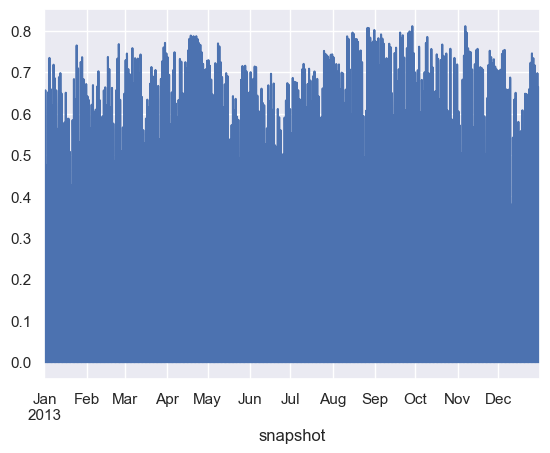

In [400]:
#capacity_factor = n.generators_t.p_max_pu.loc["2013-01-18":"2013-01-18"].groupby(n.generators.carrier, axis=1).mean()
capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean()
capacity_factor['solar'].plot()

In [401]:
g = n.generators_t.p_max_pu.filter(like="onwind", axis=1)
g.columns = g.columns.map(lambda x: " ".join(x.split()[:2]))
g_transposed = g.mean().transpose()
g_transposed
br = gpd.read_file(os.getcwd() + f"/resources/bus_regions/regions_onshore_elec_s_4.geojson").set_index("name")
br["p_max_pu"] = g_transposed
br

,x,y,country,geometry,p_max_pu
name,,,,,
BO 0,-63.298402,-17.623094,BO,"POLYGON ((-64.45460 -18.28633, -64.46771 -18.27571, -64.48284 -18....",0.284018
BO 1,-68.026092,-16.361999,BO,"POLYGON ((-69.25654 -17.95396, -69.27597 -17.96933, -69.28882 -17....",0.124509
BO 2,-65.974522,-20.430537,BO,"POLYGON ((-67.12777 -22.72211, -67.18051 -22.81397, -67.58799 -22....",0.366236
BO 3,-66.256245,-17.925660,BO,"POLYGON ((-67.01111 -19.91775, -67.09095 -19.92743, -68.26843 -19....",0.113247


In [402]:
capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].filter(like="solar",axis=1)
capacity_factor.mean()

Generator
BO 0 solar    0.239692
BO 1 solar    0.183674
BO 2 solar    0.162381
BO 3 solar    0.189422
BO 4 solar    0.213604
BO 5 solar    0.238403
dtype: float64

In [403]:
generator_list = ["onwind","solar"]
for cols in generator_list :
    potential_gen = n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].filter(regex=cols) * n.generators.loc[[idx for idx in n.generators.index if cols in idx]]['p_nom_opt']
    print(str(cols) + " maximum potential generation (MWh) = " + str(potential_gen.sum().sum()))
    print(str(cols) + " maximum anual CP = " + str(potential_gen.sum().sum()/(n.generators.p_nom_opt.filter(like=cols).sum()*8760)))


onwind maximum potential generation (MWh) = 467830.9604333917
onwind maximum anual CP = 0.366180377160026
solar maximum potential generation (MWh) = 210066.96457766087
solar maximum anual CP = 0.23835589251583816


In [404]:
n.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                3.075912e-01         1.163159e+08   
            Combined-Cycle Gas     9.936119e-01         1.072226e+08   
            Geothermal             9.999672e-01         1.651959e+07   
            Oil                    1.639300e-03         1.540271e+04   
            Onshore Wind           3.661485e-01         1.745568e+07   
            Open-Cycle Gas         6.187217e-01         6.467961e+03   
            Run of River           6.450870e-01         1.387629e+08   
            Solar                  2.383056e-01         5.116460e+06   
            load                   5.547554e-13         0.000000e+00   
Line        AC                     1.602517e-01         3.008994e+07   
Link        battery charger        2.935892e-01         1.521138e+04   
            battery discharger     2.378074e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        3.966055e-01         0.000000e+00   
Store       Battery Storage        4.883311e-01         7.160236e+03   

                                Curtailment      Dispatch  Installed Capacity  \
            carrier                                                             
Generator   Biomass                0.000000  1.934684e+06        9.902000e+01   
            Combined-Cycle Gas     0.000000  7.759156e+06        1.236330e+02   
            Geothermal             0.000000  4.818158e+05        5.500000e+01   
            Oil                    0.000000  6.016642e+00        3.100000e-02   
            Onshore Wind          40.753761  4.677902e+05        1.458000e+02   
            Open-Cycle Gas         0.000000  3.468113e+02        3.200000e-02   
            Run of River          84.508174  4.881132e+06        8.637700e+02   
            Solar                 44.335283  2.100226e+05        1.004000e+02   
            load                   0.000000  2.915795e-02        6.000000e+09   
Line        AC                          NaN -3.243860e+05        2.947950e+03   
Link        battery charger             NaN -1.015933e+03        0.000000e+00   
            battery discharger          NaN -9.143400e+02        0.000000e+00   
Load        -                           NaN -2.023504e+07                 NaN   
StorageUnit Reservoir & Dam        0.000000  4.500283e+06        1.295320e+03   
Store       Battery Storage             NaN -7.806256e-16        0.000000e+00   

                                Market Value  Operational Expenditure  \
            carrier                                                     
Generator   Biomass             3.676917e+01             4.568081e+07   
            Combined-Cycle Gas  2.728533e+01             1.044909e+08   
            Geothermal          2.719700e+01             5.052916e+03   
            Oil                 2.456191e+03             2.030124e+03   
            Onshore Wind        2.366780e+01             1.214935e+04   
            Open-Cycle Gas      2.992045e+01             6.134452e+03   
            Run of River        2.527770e+01             4.671942e+04   
            Solar               2.339469e+01             4.360838e+03   
            load                2.927832e+04             2.916085e+03   
Line        AC                 -4.010776e-03                      NaN   
Link        battery charger     2.136341e+00             0.000000e+00   
            battery discharger -1.025478e+01             0.000000e+00   
Load        -                  -2.903558e+01                      NaN   
StorageUnit Reservoir & Dam     3.381555e+01             4.554628e+04   
Store       Battery Storage    -2.757732e+19             1.016440e-18   

                                Optimal Capacity       Revenue        Supply  \
            carrier                                                            
Generator   Biomass        